<a href="https://colab.research.google.com/github/rafflds/bons_maus_pagadores_emprestimo/blob/main/Dados_emprestimos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color=red>Imports de bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.style.use('ggplot')

## <font color=green>Análise Exploratória

In [18]:
# Leitura da base de dados, tradução das colunas. Colando a colunas como cabeçario
base = pd.read_csv('credit_data.csv', encoding='utf-8',
                   names=['id','renda', 'idade', 'divida', 'resposta'],header=0)
# Retirar a coluna "id"
base = base[['renda', 'idade', 'divida','resposta']]
# Visualizar os métricas estatísticas dos dados
base.describe().T


,count,mean,std,min,25%,50%,75%,max
renda,2000.0,45331.600018,14326.327119,20014.48947,32796.459717,45789.117313,57791.281668,69995.685578
idade,1997.0,40.807559,13.624469,-52.42328,28.990415,41.317159,52.587040,63.971796
divida,2000.0,4444.369695,3045.410024,1.37763,1939.708847,3974.719419,6432.410625,13766.051239
resposta,2000.0,0.141500,0.348624,0.00000,0.000000,0.000000,0.000000,1.000000


**Informações gerais sobre a base de dados**

In [3]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   renda     2000 non-null   float64
 1   idade     1997 non-null   float64
 2   divida    2000 non-null   float64
 3   resposta  2000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 62.6 KB


**Quantidade de registros por label**

In [6]:
base.resposta.value_counts()

0    1717
1     283
Name: resposta, dtype: int64

In [10]:
duplicated = base.duplicated().sum()
print(f'Quantos valores duplicados: {duplicated}')

Quantos valores duplicados: 0


## <font color=blue>Pré-Processamento Dados

In [11]:
# Visualizar os registros com idade negativa
base.query('idade < 0')

,renda,idade,divida,resposta
15,50501.726689,-28.218361,3977.287432,0
21,32197.620701,-52.423280,4244.057136,0
26,63287.038908,-36.496976,9595.286289,0


In [46]:
# Substituir os valores negativos, existente na coluna idade, por valores positivos
def substituir_negativo(valor):
  if valor < 0:
    return -valor
  else:
    return valor

# Aplicar a função na coluna idade
base.idade = base.idade.apply(substituir_negativo)
base.query('idade < 0')


,renda,idade,divida,resposta


In [47]:
'''
Criar uma variável com média de idade
Aplicar a média dos dados nos valores faltantes
Visualizar a existência dos valores faltantes
'''
mean = base.idade.mean()
base.fillna(mean, inplace=True)
# Visualizar as devidas correções
display('Valores faltantes: ',base.isnull().sum())

'Valores faltantes: '

renda       0
idade       0
divida      0
resposta    0
dtype: int64

In [17]:
# Idade mínima passou a ser 18 anos. Antes -52 anos.
base.idade.min().round()

18.0

**Dashboards**

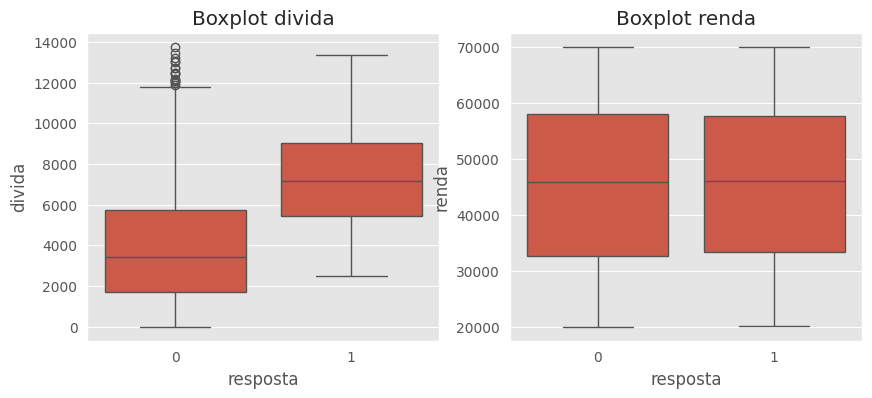

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].set_title('Boxplot divida')
sns.boxplot(x='resposta', y='divida', data=base, ax=ax[0])
ax[1].set_title('Boxplot renda')
sns.boxplot(x='resposta', y='renda', data=base, ax=ax[1])
plt.show()


In [ ]:
# prompt: criar uma variável com os outliers

outliers = base.query('renda > 70000 or renda < 10000 or idade > 100 or idade < 18')
